# BLU05 - Learning Notebook - Part 3 of 3 - Auto SARIMAX and Exogenous Features

In [1]:
import utils 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd 
import numpy as np 
import statsmodels.api as sm  # <--- Yay! API! 
%matplotlib inline 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 4)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)   
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [2]:
airlines = utils.load_airline_data()
airlines_logged = np.log(airlines)

In [3]:
train = airlines_logged[:-24]
test = airlines_logged[-24:]

## 1. pmdarima for auto-tuned models

### 1.1 Auto SARIMAX

In the previous notebook we promised to show you how to get the best parameters for SARIMAX. The time has come!

You may already be suspecting that the way to do it is to train several models in the train set using different parameters and choose the one with the lowest AIC (which already penalises complexity, so, in theory, a validation set is not needed). And you would be right! But, instead of doing it manually, we will use [pmdarima](http://alkaline-ml.com/pmdarima/), which is a wrapper around statsmodels for SARIMAX models which not only automatises the SARIMAX model selection but also offers some extra functionality that we will see later on. 

In [4]:
import pmdarima as pm

Let's use the `AutoARIMA` function which will automatically search for the best ARIMA model based on the train set. The only thing we will tell `AutoARIMA` is that we know the seasonality is of 12 periods, by using `m=12`. We could also ask `AutoARIMA` to search for it, but it would be considerably slower.

For more information on how `AutoARIMA` actually works, make sure to check the [documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html).

In [5]:
sarimax = pm.AutoARIMA(trace=True, supress_warnings=True, m=12)
sarimax.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-386.566, Time=2.41 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-277.702, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-381.231, Time=0.68 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-341.622, Time=2.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.985, Time=0.02 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-389.780, Time=3.39 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-365.956, Time=0.27 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-387.767, Time=2.73 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-383.808, Time=1.05 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-385.814, Time=2.78 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-391.122, Time=1.96 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-366.329, Time=0.34 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-388.637, Time=2.22 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-388.824, Time=3.93 sec
 ARIMA(1,0,2)(1,1,0

AutoARIMA(m=12, trace=True)

Ok! So this is how we got the hyperparameters `ARIMA(2,0,0)(0,1,1)[12]`. 

A cool thing about `pmdarima` is that it aims to mimic `sklearn`'s API (interface). So, how do you think we can get predictions from our model? Instead of `get_forecast`, we simply use `predict`:

In [6]:
sarimax_forecast = sarimax.predict(24)

Let's also check if the MAE is the same as with `statsmodels`:

In [7]:
mean_absolute_error(np.exp(sarimax_forecast),np.exp(test))

10.622681125432628

Ok, all good!

As we saw in the last notebook, it's interesting to validate how well our model performs for several samples by making multiple forecasts. We also saw that we can leave our model _static_, _refit_ it or completely _remake_ it. Leaving our model static is not as trivial in `pmdarima` as it is on `statsmodels`. Refitting on `pmdarima` is slightly different from `statsmodels`, because it has a method (`update`) which refits the model but using as initial parameters the ones from the old model.

The following loop implements multiple one-step forecasts using the `update` method from `pmdarima`. As mentioned, this is similar to refitting, but it initializes the parameters with the values from the previous fit.

In [8]:
sarimax_forecast_one_step_refit = []
sarimax.fit(train)        # Note that we're fitting the AutoArima again. This is to make sure you always 
for i in np.arange(0,24): # run it before the rest of the loop
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(test[i:i+1])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-386.566, Time=43.52 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-277.702, Time=0.69 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-381.231, Time=11.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-341.622, Time=9.35 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-118.985, Time=0.03 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-389.780, Time=2.85 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-365.956, Time=0.42 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-387.767, Time=5.14 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-383.808, Time=3.61 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-385.814, Time=7.49 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-391.122, Time=6.80 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-366.329, Time=0.37 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-388.637, Time=4.59 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-388.824, Time=3.45 sec
 ARIMA(1,0,2)(1,1

Let's take a look at the MAE:

In [9]:
mean_absolute_error(np.exp(sarimax_forecast_one_step_refit),np.exp(test))

11.099508836014154

You may remember that with `statsmodels` the one-step forecast refitted model obtained an MAE of 10.9%, but now we got 11.1%. The most probable reason is that initializing the parameters from the previous fit doesn't really help in this case. Remember that this is just one case, for another period or another dataset the situation can be the opposite.

As mentioned, instead of refitting we could also completely remake the model. This means that instead of updating the model on our `for` loop, we would fit a new auto-arima model on each step.

### 1.2 Box-Cox Transformation

Remember in the first notebook when we mentioned that the `log` transformation is just a particular case of the Box-Cox transformation? Well, `pmdarima` makes it easy to automate Box-Cox to find the best transformation to unskew our distribution. `pmdarima` also has pipelines similar to `sklearn`, making it easy to create a pre-processing and modelling pipeline. This means all the Box-Cox transformations and inverse transformations are implicitly calculated :)

Note: pipelines were first introduced in SLU16

In [10]:
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

In [11]:
train = airlines[:-24]
test = airlines[-24:]

In [12]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=12
                          )
    )
])

sarimax_pipeline.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=-288.002, Time=1.98 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-182.354, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-284.619, Time=0.48 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=-247.225, Time=0.42 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-21.412, Time=0.01 sec
 ARIMA(2,0,2)(0,1,1)[12] intercept   : AIC=-291.988, Time=1.46 sec
 ARIMA(2,0,2)(0,1,0)[12] intercept   : AIC=-270.150, Time=0.21 sec
 ARIMA(2,0,2)(0,1,2)[12] intercept   : AIC=-289.992, Time=2.72 sec
 ARIMA(2,0,2)(1,1,0)[12] intercept   : AIC=-286.728, Time=1.13 sec
 ARIMA(2,0,2)(1,1,2)[12] intercept   : AIC=-288.160, Time=4.63 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=-293.268, Time=1.26 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=-270.476, Time=0.17 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=-290.028, Time=1.22 sec
 ARIMA(1,0,2)(0,1,2)[12] intercept   : AIC=-291.290, Time=2.11 sec
 ARIMA(1,0,2)(1,1,0)

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1e-06)),
                ('arima', AutoARIMA(m=12, trace=True))])

In [13]:
mean_absolute_error(sarimax_pipeline.predict(24),test)

10.135745363179161

Wow, that's almost a 10% improvement compared to the one with the `log` transform. Great!

# 2. New Challenge!

You have been learning a lot, but I bet you're already tired of looking at yearly air passengers on every plot. 

Let's test your new skills on a new dataset - now on solar energy - and take the opportunity to mature the standard workflow.

In [15]:
df = pd.read_csv('data/pv.csv')
df.Datetime = pd.to_datetime(df.Datetime)
df = df.set_index('Datetime')
df = df.sort_index()
train = df.loc[:'2016-01-15']
test = df.loc['2016-01-16':'2016-02-01']

First, let's take a look at the data:

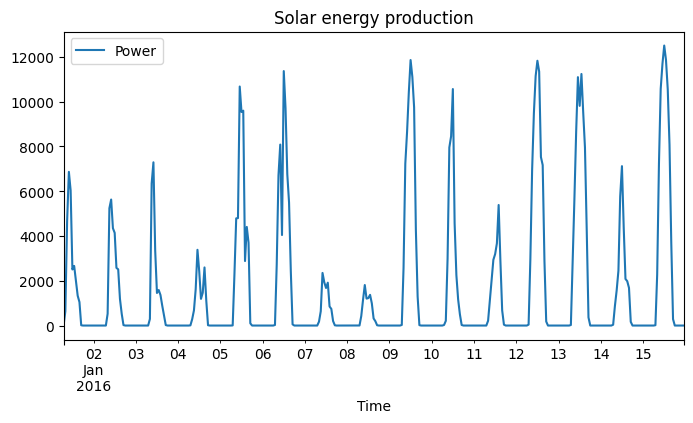

In [16]:
train.plot()
plt.title('Solar energy production')
plt.xlabel('Time')
plt.show()

The data clearly seems to have some seasonality going on. On the other hand, there doesn't seem to be any significant trend. The variance also changes quite significantly, but without a clear pattern. Let's check the ACF plot to better understand the patterns going on.

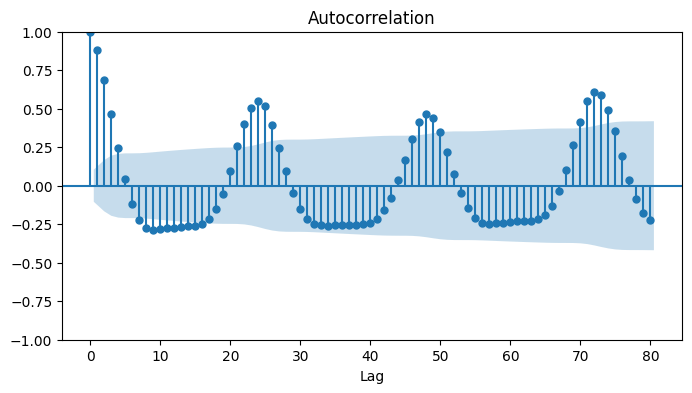

In [17]:
plot_acf(train.dropna(), alpha=.05, lags=80)  
plt.xlabel('Lag')
plt.show()

From the ACF plot we can clearly see a daily (24 hours) seasonality, which makes sense given what we know about our day-night pattern (this is what we call as domain knowledge, our understanding of the problem at hand).

Also, note from the timeseries plot that we have values of 0, which can be problematic when taking the Box-Cox transform, so let's use `lmbda2=1` which adds a constant of 1 to the data to make it non-zero when applying the transformation.

In [18]:
sarimax_pipeline = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           maxiter=10, # Let's also reduce maxiter to make it faster.
                           
                          )
    )
])

sarimax_pipeline.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=432.795, Time=1.90 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1591.497, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=994.550, Time=1.42 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1791.622, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=764.173, Time=1.08 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=535.111, Time=1.79 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=350.333, Time=7.61 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=343.571, Time=6.60 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=368.755, Time=3.87 sec
 ARIMA(2,0,1)(2,0,0)[24] intercept   : AIC=373.593, Time=2.24 sec
 ARIMA(3,0,2)(2,0,0)[24] intercept   : AIC=357.715, Time=4.16 sec
 ARIMA(2,0,3)(2,0,0)[24] intercept   : AIC=374.866, Time=4.40 sec
 ARIMA(1,0,1)(2,0,0)[24] intercept   : AIC=369.575, Time=1.71 sec
 ARIMA(1,0,3)(2,0,0)[24] intercept 

Pipeline(steps=[('boxcox', BoxCoxEndogTransformer(lmbda2=1)),
                ('arima', AutoARIMA(m=24, maxiter=10, trace=True))])

Let's look at the in-sample predictions:

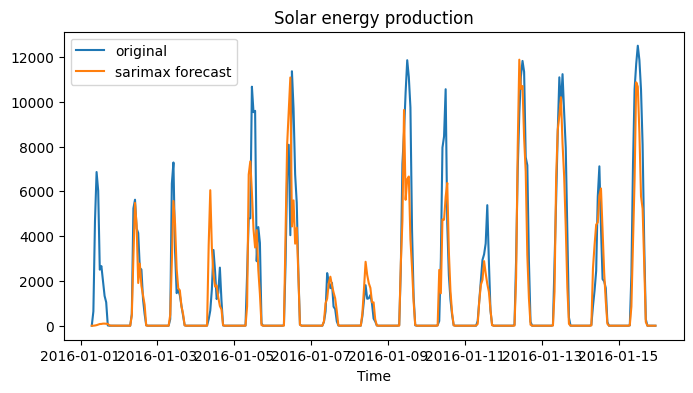

In [19]:
plt.plot(train, label='original')
plt.plot(train.index, sarimax_pipeline.predict_in_sample(), label='sarimax forecast')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend()
plt.show()

In [20]:
mean_absolute_error(sarimax_pipeline.predict_in_sample(),train)

683.9381488277318

The model seems to have captured the seasonality quite well, but the changing intra-day variance not so much. Let's look at a multi-step forecast:

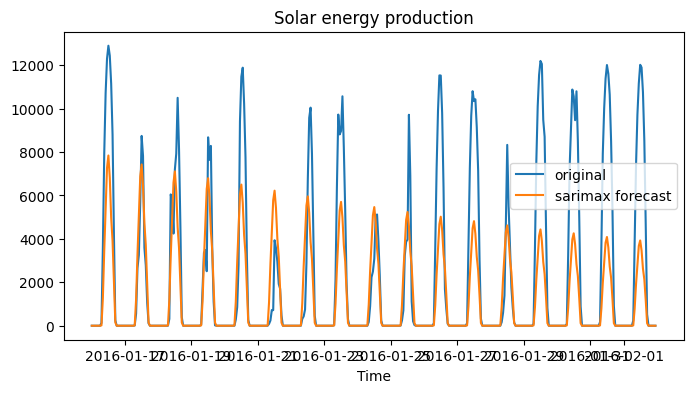

In [21]:
plt.plot(test, label='original')
plt.plot(test.index, sarimax_pipeline.predict(17*24), label='sarimax forecast')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend()
plt.show()

In [22]:
mean_absolute_error(sarimax_pipeline.predict(17*24), test)

1329.1525972340462

The model clearly didn't capture any patterns which explain the variance changes throughout the timeseries. This probably means there's something missing on our model. Indeed, it makes sense that there is some temporal relation in solar production (the well-known daily day-night cycle), but not all days are equal right? There is something that **causes** some days to produce more power than others. Indeed, some days are sunnier (or the other way around, cloudier) than others.

Let's think a bit more about our problem at hand and look how we can incorporate that into our model next.

### 2.2 Exogenous variables in SARIMAX

#### Some bits of domain knowledge

As you may have guessed, **solar energy production depends mainly on incoming sunlight (or solar radiation).**

Thus, when forecasting solar power, the variable we really want to have is solar radiation. But note that we can't simply use solar radiation measurements contemporary to our forecast times, as this would mean that you had them before they actually happened! Are you a magician or do we need to find an alternative?

Ok, so let's go with option B. Think about how you decide to take an umbrella with you when you leave your house...
I guess that, _if you're not really a magician_, you look at the weather forecast. And what is it that weather impacts a lot? Solar radiation and it's intra-day variance! This is a quite common weather forecast variable, such as wind speed, precipitation, etc. **Since these are produced ahead of time (it is a forecast), we can use it in an operational context.**


<img src="media/radiation_inputs.jpg" alt="Drawing" style="width: 350px;">

#### Exogenous and Endogenous Variables

When added to a forecasting model, we call an external variable such as the solar radiation forecast as an **exogenous variable**. And it is important that when you choose such variables for you model to keep in mind two things:
- *independence* as, ideally, your exogenous input should be independent from your prediction;
- *causality* and the mantra "_Correlation does not imply causation_".

About the first point, just imagine you have a model that predicts the price of a product based on (1) demand and (2) past price values. You might be tempted to think that (1) is exogenous. But economists know that if you lower the price of a good, people will be more open to acquiring more of it. And, as such, the demand is not independent the predictions your model does, even more if you use those predictions to set the price. 

The second point was already discussed in the bootcamp SLU05, but if you don't remember why, check this [website](https://www.tylervigen.com/spurious-correlations). If this really piques your interest, consider this [book reading suggestion](https://www.goodreads.com/book/show/36204378-the-book-of-why).

On other side of the variable spectrum, we have our solar energy production lagged values (or (2) in the price prediction example). These we call as **endogenous variables**.

The definition of these concepts is not consensual, but a simplistic view is that lagged values of your target variable are **endogenous** and everything else is **exogenous**. A more complex one considers that any variable which depends on the forecast target is also **endogenous** (example for our case study: typical solar generators produce less the hotter they are, but they also get hotter the more they produce).

If you want to pursue further these concepts, you might want to take a look at:
- [Endogenous](https://www.merriam-webster.com/dictionary/endogenous) and [exogenous](https://www.merriam-webster.com/dictionary/exogenous) definitions
- this links from [Statistics How To](https://www.statisticshowto.com/endogenous-variable/), [Machine Learning Mastery](https://machinelearningmastery.com/taxonomy-of-time-series-forecasting-problems/#:~:text=An%20input%20variable%20is%20endogenous,%2D2%2C%20and%20so%20on)
- or this economics-inspired webpage from [Reed College](https://www.reed.edu/economics/course_pages.archive/red_spots/endogenous_and_exogenous_v.htm) and [Youtube video](https://www.youtube.com/watch?v=qiQhAyuH2P4) from Free Econ Help

#### Enough chitchat, let's (finally) get our hands dirty with SARIMAX

Let's load a radiation forecast dataset. Note that the index of this dataset doesn't correspond to the measure date, it corresponds to the forecasts date. And all these forecasts were made the month before, so this means we can use them for next month's forecasts.

In [23]:
exog = pd.read_csv('data/radiation.csv')
exog.Datetime = pd.to_datetime(exog.Datetime)
exog = exog.set_index('Datetime')
exog = exog.sort_index()
exog_train = exog['2016-01-01 07':'2016-01-15']
exog_test = exog['2016-01-16':'2016-02-01']

In [24]:
sarimax_pipeline_exog = Pipeline([  #The Box-Cox transform has been removed because it messes with the exogenous input
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,
                           m=24, 
                           maxiter=10,
                           
                          )
    )
])

sarimax_pipeline_exog.fit(train,exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=5303.308, Time=0.94 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=5539.610, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=5294.104, Time=0.65 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=5382.486, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=5551.656, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=5302.111, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=5295.424, Time=2.30 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=5296.658, Time=0.77 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=5294.820, Time=0.76 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=5300.167, Time=4.18 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=5541.184, Time=0.26 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=5296.197, Time=0.46 sec
 ARIMA(1,0,1)(1,0,0)[24] intercept   : AIC=5295.873, Time=0.41 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=5382.489, Time=0.30 sec
 ARIMA(2,0,1)(1,0,0

Pipeline(steps=[('arima', AutoARIMA(m=24, maxiter=10, trace=True))])

Let's look at the in-sample predictions:

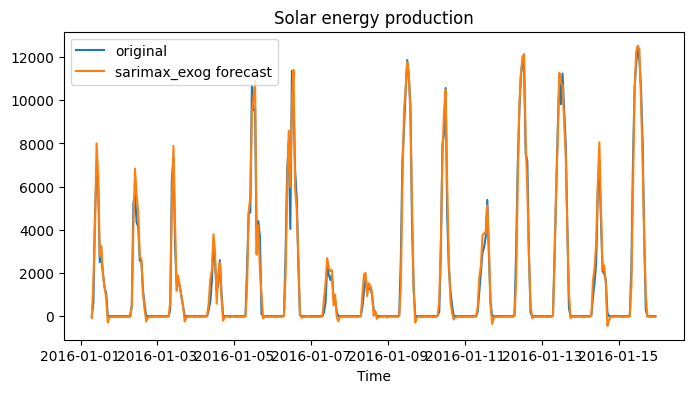

In [25]:
plt.plot(train, label='original')
plt.plot(train.index, sarimax_pipeline_exog.predict_in_sample(exog_train), label='sarimax_exog forecast')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend()
plt.show()

In [26]:
mean_absolute_error(sarimax_pipeline_exog.predict_in_sample(exog_train),train)

237.77967415471159

It captured the variance changes much better! What about the multi-step forecast?

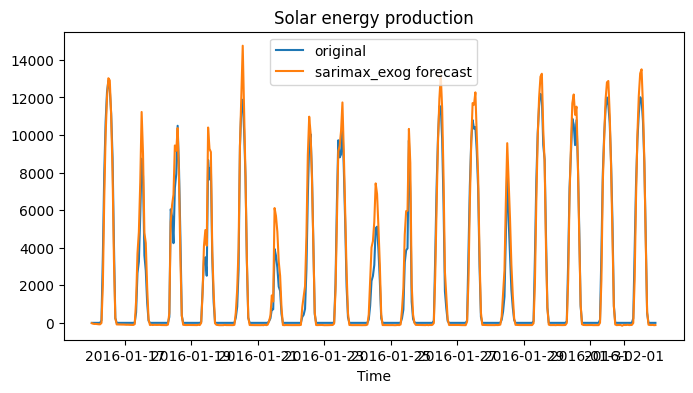

In [27]:
plt.plot(test, label='original')
plt.plot(test.index, sarimax_pipeline_exog.predict(29*24,exog_test), label='sarimax_exog forecast')
plt.xlabel('Time')
plt.title('Solar energy production')
plt.legend()
plt.show()

In [28]:
mean_absolute_error(sarimax_pipeline_exog.predict(29*24,exog_test),test)

437.1490772672654

Looking good! And we can see the MAE is more than less compared with not using exogenous variables. This is a context where the use of exogenous variables clearly improves performance. But there are many other cases such as this one. For example, to forecast supermarket sales it might be relevant to take into account temperature forecasts; to forecast wind power we need to take into account wind forecasts, etc.

## 3. Confidence Intervals

Also, have we told you that you can also get confidence intervals for free? Simply use `return_conf_int=True`:

In [29]:
preds = sarimax_pipeline_exog.predict(24*7,exog_test[:24*7], return_conf_int=True)

In [30]:
def plot_predictions(series_, pred_):
    
    """ 
    Remember Sam told us to build functions as we go? Let's not write this stuff again. 
    """
    
    mean_predictions_ = pd.Series(pred_[0], index=series_.index)

    pred_ci_ = pd.DataFrame(pred_[1], columns=['lower bound', 'upper bound'],
                           index=series_.index)
    
    series_.plot(label='observed')
    mean_predictions_.plot(label='predicted', 
                           alpha=.7)

    plt.fill_between(pred_ci_.index,
                     pred_ci_['lower bound'],
                     pred_ci_['upper bound'], 
                     color='k', 
                     alpha=.2)

    plt.xlabel('Time')
    plt.title('Solar energy production')
    plt.legend()
    plt.show()

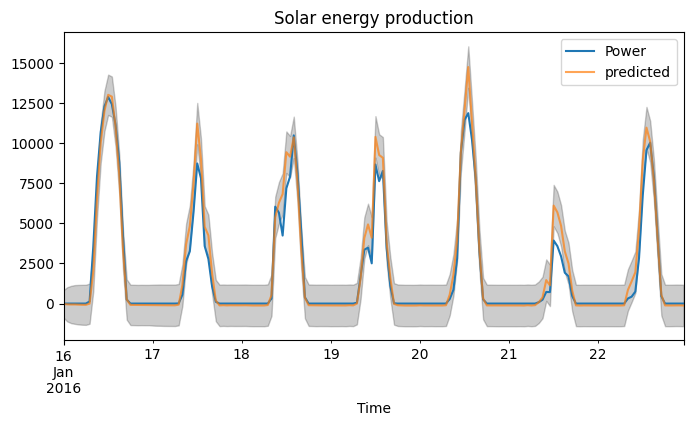

In [31]:
plot_predictions(test['2016-01-16':'2016-01-22'], preds)

Confidence intervals can be very useful for business-driven decisions. In most real scenarios we're not only interested in the forecasted value but also in the uncertainty associated to it.

Note that we've been talking mostly about timeseries forecasting, but there are many other machine learning applications related to timeseries: timeseries classification; anomaly detection; change point detection, etc. 

Confidence intervals are particularly important for anomaly detection. You can imagine that when we have real values that fall considerably out of our forecast bounds, then we may have some abnormal behavior. For a quick intro to some of the concepts in timeseries anomaly detection check out this [article](https://docs.microsoft.com/en-us/azure/machine-learning/studio-module-reference/time-series-anomaly-detection).